In [1]:
import torch
from torch import nn, Tensor, from_numpy
import torch.nn.functional as F
import torch.optim as optim

from utils import get_data_generator, get_data_tensor, replace_activations
from config import load_config
import numpy as np
import matplotlib.pyplot as plt
from diffusion import get_ddpm

import wandb
from tqdm import trange
from denoising_diffusion_pytorch import Unet

from utils import LeNet, compute_fid, extract_features_statistics
from torch.utils.data import DataLoader

/home/coder/.local/lib/python310-conda-cuda-torch21/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = load_config()
train_data = get_data_tensor(config)
test_data = get_data_tensor(config, train=False)

In [3]:
# ---------------------------
# Helper blocks
# ---------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, downsample: bool = True) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2 if downsample else 1, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x: Tensor) -> Tensor:
        return self.lrelu(self.norm(self.conv(x)))


class UpConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x: Tensor) -> Tensor:
        if self.upsample:
            x = self.upsample(x)
        return self.lrelu(self.norm(self.conv(x)))


# ---------------------------
# Residual block for the bottleneck.
# ---------------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(channels)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(channels)

    def forward(self, x: Tensor) -> Tensor:
        residual = x
        out = self.lrelu(self.norm1(self.conv1(x)))
        out = self.norm2(self.conv2(out))
        return self.lrelu(out + residual)


# ---------------------------
# Generator with configurable layer sizes using hyperparameter "dim_mults"
# ---------------------------
class DDGANGenerator(nn.Module):
    def __init__(self, in_channels: int = 3, base_channels: int = 64, dim_mults: list[int] = [1, 2, 4],
                 num_res_blocks: int = 2) -> None:
        """
        Args:
            in_channels: Number of channels in the input latent (e.g. from autoencoder)
            base_channels: Base number of channels to multiply by each factor in dim_mults
            dim_mults: List of multipliers controlling the number of channels at each encoder stage.
                       For example, [1, 2, 4] creates encoder channels: base_channels, 2*base_channels, 4*base_channels.
            num_res_blocks: Number of residual blocks at the bottleneck.
        """
        super().__init__()
        self.dim_mults = dim_mults

        channels = [in_channels, *(base_channels * mult for mult in dim_mults)]
        encoder_in_out_channels = list(zip(channels, channels[1:]))
        decoder_in_out_channels = map(reversed, reversed(encoder_in_out_channels))

        # Build Encoder dynamically
        self.encoder_blocks = nn.ModuleList()
        
        for current_channels, out_channels in encoder_in_out_channels:
            self.encoder_blocks.append(ConvBlock(current_channels, out_channels, downsample=True))

        # Bottleneck: add residual blocks
        self.res_blocks = nn.Sequential(*[ResidualBlock(channels[-1]) for _ in range(num_res_blocks)])

        # Build Decoder dynamically (reverse order of encoder dims)
        decoder_dims = list(reversed(dim_mults))
        self.decoder_blocks = nn.ModuleList()
        for i, (current_channels, out_channels) in enumerate(decoder_in_out_channels):
            # For the last decoder block, do not upsample.
            self.decoder_blocks.append(UpConvBlock(current_channels, out_channels))

        # Final convolution to produce output with same channels as input
        self.out_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Input latent (noisy latent code) of shape (N, C, H, W)
            t: Current diffusion timestep (can be used for conditioning)
            noise: Additional noise to inject (for diffusion process)
        Returns:
            Denoised latent representation.
        """
        # Encoder forward pass with saving features for skip connections.
        enc_features: list[Tensor] = []
        for block in self.encoder_blocks:
            enc_features.append(x)
            x = block(x)            

        # Bottleneck
        x = self.res_blocks(x)

        # Decoder forward pass with skip connections (using reversed order)
        enc_features = enc_features[::-1]  # Reverse list for skip connections
        for i, block in enumerate(self.decoder_blocks):
            x = block(x) + enc_features[i]

        # Final output convolution
        x = self.out_conv(x)
        return x


# ---------------------------
# Multi-scale discriminator
# ---------------------------
class Discriminator(nn.Module):
    def __init__(self, in_channels: int = 3, base_channels: int = 64, dim_mults: list[int] = [1, 2, 4]) -> None:
        super().__init__()
        channels = [in_channels, *(base_channels * dim_mult for dim_mult in dim_mults)]
        self.conv_blocks = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True),
                )
                for in_channels, out_channels in zip(channels, channels[1:])
            ],
            nn.Conv2d(channels[-1], channels[-1], kernel_size=2, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.last_linear = nn.Linear(channels[-1], 1)

    def forward(self, imgs: Tensor, noisy_imgs: Tensor) -> Tensor:
        return self.last_linear(self.conv_blocks(torch.cat([imgs, noisy_imgs], dim=1)).flatten(1))


# ---------------------------
# Loss functions: Adversarial and Reconstruction
# ---------------------------
def real_loss(logits: Tensor) -> Tensor:
    return F.softplus(-logits).mean()


def fake_loss(logits: Tensor) -> Tensor:
    return F.softplus(logits).mean()


def generator_loss(fake_logits: Tensor) -> Tensor:
    return real_loss(fake_logits)


def discriminator_loss(real_logits: Tensor, fake_logits: Tensor) -> Tensor:
    return 0.5 * (0.8 * real_loss(real_logits) + 0.2 * fake_loss(real_logits) + 0.8 * fake_loss(fake_logits) + 0.2 * fake_loss(fake_logits))


def reconstruction_loss(reconstructed: Tensor, target: Tensor) -> Tensor:
    return F.l1_loss(reconstructed, target)


# ---------------------------
# Noise
# ---------------------------
def add_noise(imgs: Tensor, temp: float) -> Tensor:
    return (imgs + temp ** 0.5 * torch.randn_like(imgs)) / (1 + temp) ** 0.5


# ---------------------------
# Training step example
# ---------------------------
def train_step(
        generator: nn.Module,
        discriminator: nn.Module,
        optimizer_G: torch.optim.Optimizer,
        optimizer_D: torch.optim.Optimizer,
        real_imgs: Tensor,
        temp: float,
        discriminator_only: bool = False,
) -> tuple[float, float]:
    """
    Args:
        generator: The generator network.
        discriminator: The multi-scale discriminator.
        optimizer_G: Optimizer for the generator.
        optimizer_D: Optimizer for the discriminator.
        real_latents: Real latent codes (from a pretrained autoencoder) of shape (N, C, H, W).
        diffusion_coeff: Coefficient for the forward diffusion process.
        timestep: Current diffusion timestep (conditioning input).
    Returns:
        Tuple containing (generator loss, discriminator loss).
    """
    device = real_imgs.device
    noisy_imgs = add_noise(real_imgs, temp)
    fake_imgs = generator(noisy_imgs)
    # -----------------
    # Discriminator update
    # -----------------
    optimizer_D.zero_grad()
    d_loss = discriminator_loss(
        discriminator(add_noise(real_imgs, 0), noisy_imgs),
        discriminator(fake_imgs.detach(), noisy_imgs)
    )
    d_loss.backward()
    optimizer_D.step()

    if discriminator_only:
        return torch.zeros(1), d_loss

    # -----------------
    # Generator update
    # -----------------
    optimizer_G.zero_grad()
    g_loss = generator_loss(discriminator(fake_imgs, noisy_imgs))
    g_loss.backward()
    optimizer_G.step()

    return g_loss.item(), d_loss.item()


In [4]:
# def replace_activations(module):
#     if isinstance(module, nn.ReLU) or isinstance(module, nn.SiLU) or isinstance(module, nn.GELU):
#         return nn.LeakyReLU(0.2, inplace=True)
#     return module

# # Apply the function recursively to replace activations



class DDGANGenerator(nn.Module):
    def __init__(self, t: float = 1e-3):
        super().__init__()

        self.ddpm = get_ddpm(config)
        self.t = t

    def forward(self, x: Tensor) -> Tensor:
        return self.ddpm(x, torch.full((len(x),), self.t, device=x.device))

In [5]:
lenet = LeNet(1024, 10).cuda()
lenet.load_state_dict(torch.load("checkpoints/lenet_mnist.pth"))

mu, sigma = extract_features_statistics(train_data.cuda(), lenet)

diffusion_samples = np.load(config.samples_path)
states = from_numpy(diffusion_samples["states"])
diff_imgs = states[:, 0]
x = from_numpy(diffusion_samples["x"])

noisy_test_data_loader = DataLoader(add_noise(test_data, 1e-2), batch_size=1000)

mu_diff, sigma_diff = extract_features_statistics(x.cuda(), lenet)
compute_fid(mu, sigma, mu_diff, sigma_diff + 1e-7)

(0.5243606, 1.4768769742086572, 2.0012375713422936)

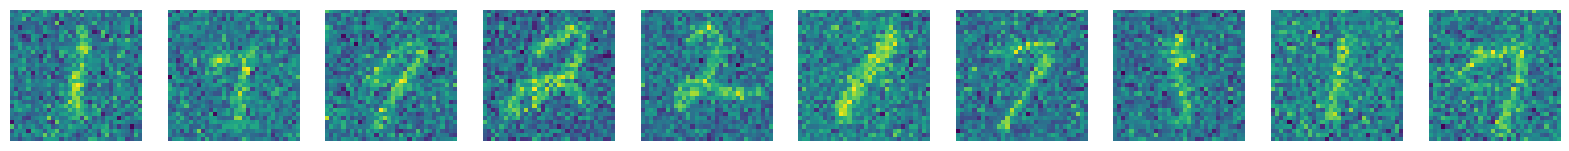

In [6]:
plt.figure(figsize=(20, 2))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(diff_imgs[i, 0])
    plt.axis("off")

In [7]:
device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
in_channels: int = 1
base_channels: int = 64
dim_mults: list[int] = [1, 2, 4, 4]
num_res_blocks: int = 2

# Instantiate models
# generator = DDGANGenerator(in_channels, base_channels, dim_mults, num_res_blocks).to(device)
generator = DDGANGenerator().to(device)
discriminator = Discriminator(2 * in_channels, 64, dim_mults).to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999), weight_decay=1e-3)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))
# optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=1e-2, momentum=0.5, weight_decay=1e-3)
num_steps = 50000

# Data
batch_size = 128
train_data_generator = get_data_generator(train_data, batch_size=batch_size)
temp = 0.14

wandb.init(project="One-step gan denoiser")

# Warmup
# cnt = 0
# while True:
#     real_imgs = next(train_data_generator).to(device)
#     _, d_loss = train_step(
#         generator,
#         discriminator,
#         optimizer_G,
#         optimizer_D,
#         real_imgs,
#         temp,
#         discriminator_only=True,
#     )

#     wandb.log({
#         "D_loss_warmup": d_loss,
#     })

#     cnt += d_loss < 0.3
#     if cnt > 100:
#         break

for step in trange(num_steps):
    real_imgs = next(train_data_generator).to(device)
    g_loss, d_loss = train_step(
        generator,
        discriminator,
        optimizer_G,
        optimizer_D,
        real_imgs,
        temp,
    )

    wandb.log({
        "Step": step,
        "G_loss": g_loss,
        "D_loss": d_loss,
    })

    if (step + 1) % 2000 == 0:
        fake_imgs = torch.cat([torch.clip(generator(batch.to(device)).detach().cpu(), 0., 1.) for batch in DataLoader(diff_imgs, batch_size=1000)], dim=0)
        mu_eval, sigma_eval = extract_features_statistics(fake_imgs.cuda(), lenet)
        diff_fid = compute_fid(mu, sigma, mu_eval, sigma_eval + 1e-5)[2]

        fake_imgs = torch.cat([torch.clip(generator(batch.to(device)).detach().cpu(), 0., 1.) for batch in noisy_test_data_loader], dim=0)
        mu_eval, sigma_eval = extract_features_statistics(fake_imgs.cuda(), lenet)
        test_fid = compute_fid(mu, sigma, mu_eval, sigma_eval + 1e-5)[2]

        wandb.log({
            "Diffusion eval fid": diff_fid,
            "Test eval fid": test_fid,
        })

    if (step + 1) % 2000 == 0:
        real_imgs = test_data[:10]
        noisy_imgs = add_noise(real_imgs, temp)
        fake_imgs = generator(noisy_imgs.to(device)).detach().cpu()

        fig = plt.figure(figsize=(20, 5))

        for i in range(10):
            plt.subplot(3, 10, i + 1)
            plt.imshow(real_imgs[i, 0])
            plt.axis("off")

            plt.subplot(3, 10, i + 11)
            plt.imshow(noisy_imgs[i, 0])
            plt.axis("off")

            plt.subplot(3, 10, i + 21)
            plt.imshow(fake_imgs[i, 0])
            plt.axis("off")

        wandb.log({"Generated samples": wandb.Image(fig)})
        plt.close(fig)

wandb.finish()

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


wandb: Currently logged in as: antonii-belyshev to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


  0%|          | 0/50000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
  4%|▍         | 2000/50000 [05:51<122:33:11,  9.19s/it]/opt/conda/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
 49%|████▉     | 24507/50000 [2:03:11<2:08:08,  3.32it/s]  


KeyboardInterrupt: 

In [9]:
fake_imgs = torch.cat([torch.clip(generator(batch.to(device)).detach().cpu(), 0., 1.) for batch in noisy_test_data_loader], dim=0)
mu_eval, sigma_eval = extract_features_statistics(fake_imgs.cuda(), lenet)
compute_fid(mu, sigma, mu_eval, sigma_eval + 1e-5)[2]

3.4807548488787132

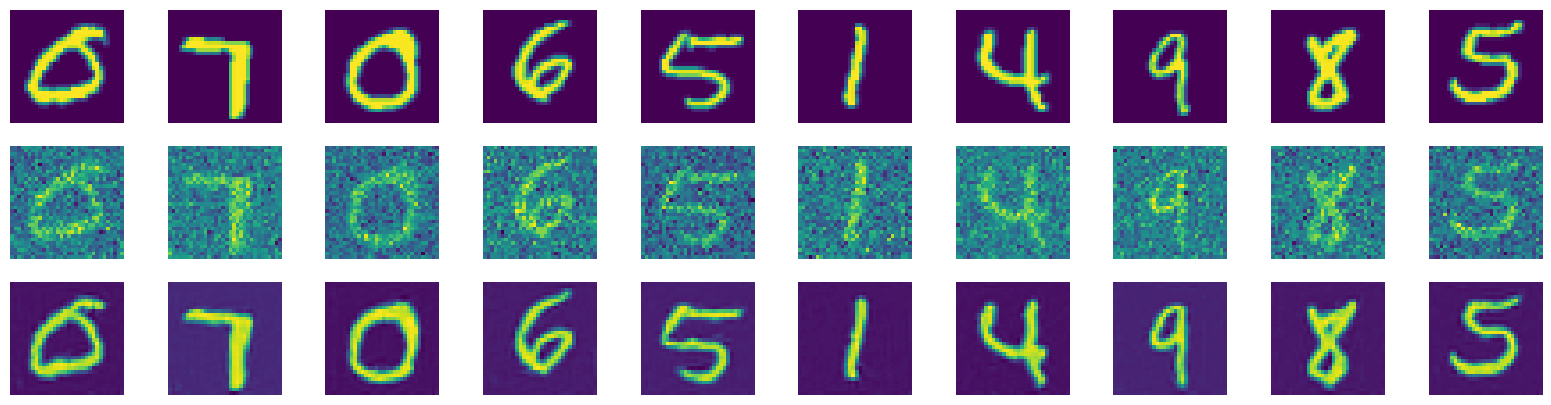

In [10]:
real_imgs = next(train_data_generator)
noisy_imgs = add_noise(real_imgs, temp)
fake_imgs = generator(noisy_imgs.to(device)).detach().cpu()


plt.figure(figsize=(20, 5))

for i in range(10):
    plt.subplot(3, 10, i + 1)
    plt.imshow(real_imgs[i, 0])
    plt.axis("off")
    plt.subplot(3, 10, i + 11)
    plt.imshow(noisy_imgs[i, 0])
    plt.axis("off")
    plt.subplot(3, 10, i + 21)
    plt.imshow(fake_imgs[i, 0])
    plt.axis("off")

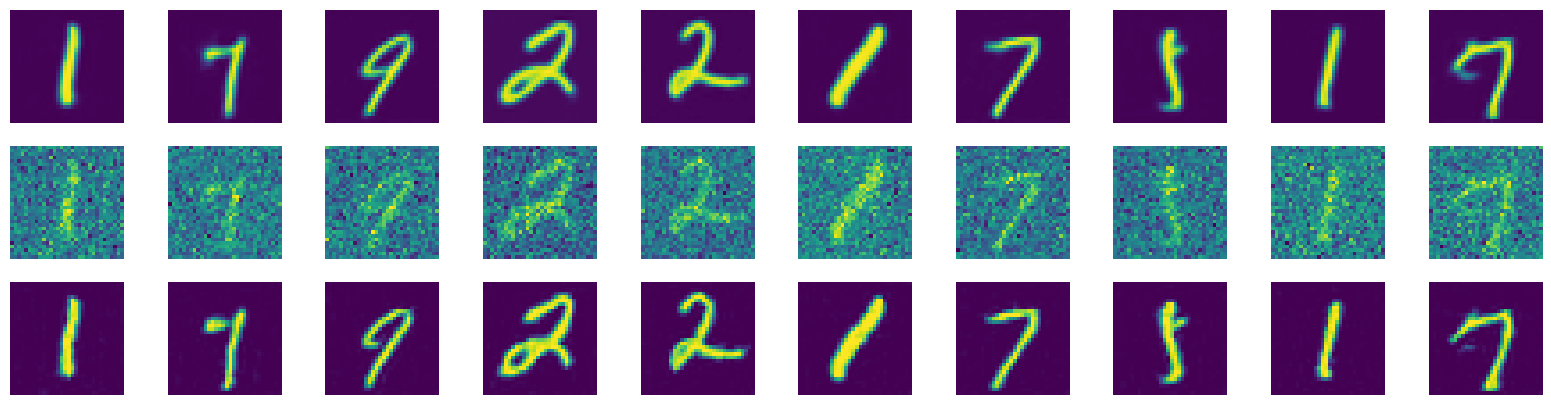

In [11]:
from torch.utils.data import DataLoader


fake_imgs = torch.cat([torch.clip(generator(batch.to(device)).detach().cpu(), 0., 1.) for batch in DataLoader(diff_imgs, batch_size=500)], dim=0)


plt.figure(figsize=(20, 5))

for i in range(10):
    plt.subplot(3, 10, i + 1)
    plt.imshow(x[i, 0])
    plt.axis("off")
    plt.subplot(3, 10, i + 11)
    plt.imshow(diff_imgs[i, 0])
    plt.axis("off")
    plt.subplot(3, 10, i + 21)
    plt.imshow(fake_imgs[i, 0])
    plt.axis("off")

In [12]:
mu_eval, sigma_eval = extract_features_statistics(fake_imgs.cuda(), lenet)
compute_fid(mu, sigma, mu_eval, sigma_eval + 1e-7)

(3.3657963, 5.440840066666384, 8.806636394257326)

In [13]:
mu_x, sigma_x = extract_features_statistics(x.cuda(), lenet)
compute_fid(mu, sigma, mu_x, sigma_x + 1e-7)

(0.5243606, 1.4768769742086572, 2.0012375713422936)

In [14]:
mu_x, sigma_x = extract_features_statistics(torch.clip(x, 0, 1).cuda(), lenet)
compute_fid(mu, sigma, mu_x, sigma_x + 1e-7)

(0.58181274, 1.5802078281226337, 2.162020567494887)

In [15]:
ф
torch.save(generator.state_dict(), "checkpoints/generator_lrelu.pth")

NameError: name 'ф' is not defined